# Thin-Film Structure Optimization with DoG Optimizer

This example shows the application of JaxLayerLumos to thin-film structure optimization.
In this example, we use the [DoG optimizer](https://optax.readthedocs.io/en/latest/api/contrib.html#optax.contrib.dog) [1], included in [optax](https://github.com/google-deepmind/optax).

[1] Maor Ivgi, Oliver Hinder, and Yair Carmon. [DoG is SGD’s best friend: A parameter-free dynamic step size schedule](https://arxiv.org/abs/2302.12022). In *Proceedings of the International Conference on Machine Learning*, pp. 14465-14499, 2023.

Some required packages are imported first.

In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import matplotlib.pyplot as plt

import jaxlayerlumos as jll
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_units as jll_utils_units

We define a three-layer structure with TiO$_2$/Ag/TiO$_2$ for reflection.

In addition, a random seed and the number of iterations for structure optimization are declared.

In [2]:
str_mode = "reflection"
materials = ["Air", "TiO2", "Ag", "TiO2", "FusedSilica"]
num_layers = len(materials) - 2

seed = 84
num_iter = 100

In the next cell, frequencies, wavelengths, and wavelengths in nanometers are defined, and the n and k values of the structure are obtained from JaxLayerLumos.

In [3]:
frequencies = jll_utils_spectra.get_frequencies_visible_light()
wavelengths = jll_utils_spectra.convert_frequencies_to_wavelengths(frequencies)
wavelengths_in_nm = wavelengths / jll_utils_units.get_nano()

n_k = jll_utils_materials.get_n_k(materials, frequencies)

print(f"frequencies.shape {frequencies.shape}")
print(f"wavelengths.shape {wavelengths.shape}")
print(f"wavelengths_in_nm.shape {wavelengths_in_nm.shape}")
print(f"n_k.shape {n_k.shape}")

frequencies.shape (1001,)
wavelengths.shape (1001,)
wavelengths_in_nm.shape (1001,)
n_k.shape (1001, 5)


We choose a simple target spectrum over the frequencies of interest.

In [4]:
target_spectrum = jnp.zeros_like(frequencies)
target_spectrum = target_spectrum.at[:200].set(0.2)
target_spectrum = target_spectrum.at[700:].set(0.2)

We plot the target spectrum.

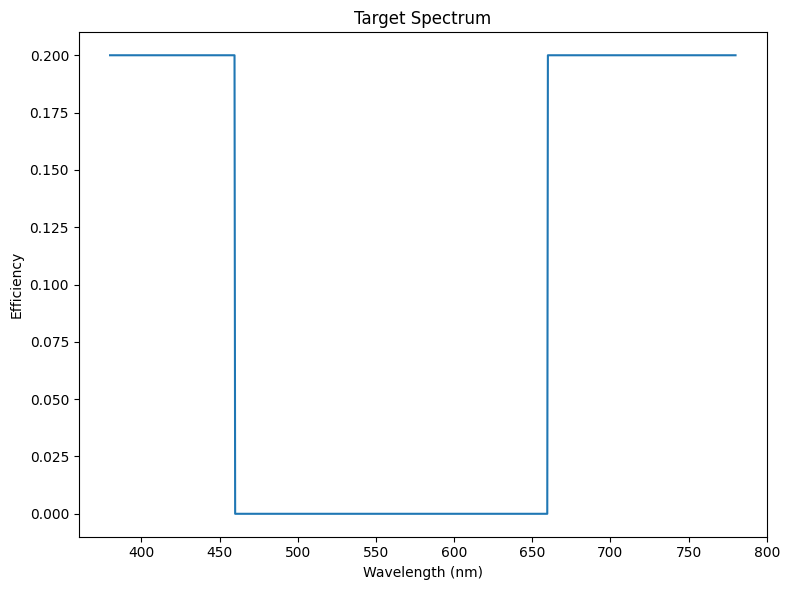

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(wavelengths_in_nm, target_spectrum)

ax.set_title(f"Target Spectrum")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Efficiency")

plt.tight_layout()
plt.show()

`transform` is to clip thicknesses to non-negative values, concatenate 0 into the beginning and end of the thicknesses, and multiply 10$^{-9}$ to the thicknesses.

`get_spectrum` is to calculate the transmission or reflection spectrum of a thin-film structure with thicknesses at a normal angle.

`objective` defines a squared residual between the target spectrum and the spectrum of the current structure.

In [6]:
def transform(inputs):
    thicknesses = jnp.clip(inputs, min=0)
    thicknesses = jnp.concatenate([
        jnp.array([0]),
        thicknesses,
        jnp.array([0])
    ], axis=0)
    thicknesses *= jll_utils_units.get_nano()

    return thicknesses

def get_spectrum(inputs):
    angles = jnp.array([0.0])
    thicknesses = transform(inputs)

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, thetas=angles)

    R_TE = R_TE[0]
    T_TE = T_TE[0]
    R_TM = R_TM[0]
    T_TM = T_TM[0]

    if str_mode == "transmission":
        spectrum = (T_TE + T_TM) / 2
    elif str_mode == "reflection":
        spectrum = (R_TE + R_TM) / 2
    else:
        raise ValueError

    return spectrum

def objective(inputs, target_spectrum):
    spectrum = get_spectrum(inputs)
    loss = jnp.sum(jnp.abs(spectrum - target_spectrum)**2)

    return loss

The next cell carries out the structure optimization with the DoG optimizer for `num_iter` iterations.

The initial thicknesses are set by sampling them from a uniform distribution $\mathcal{U}(0, 100)$.
Note that they are in nanometers.

In [7]:
params = jax.random.uniform(jax.random.key(seed), shape=(num_layers, ), minval=0, maxval=100)

optimizer = optax.contrib.dog()
optimizer_state = optimizer.init(params)

fun_objective = lambda inputs: objective(inputs, target_spectrum)

parameters = []
loss_values = []

for ind in range(0, num_iter):
    values, grads = jax.value_and_grad(fun_objective)(params)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params, value=values)
    params = optax.apply_updates(params, updates)

    loss_value = fun_objective(params)

    parameters.append(onp.array(params))
    loss_values.append(loss_value)

    print(f"Iteration {ind + 1}: {loss_value:.8f}", flush=True)

Iteration 1: 551.35784461
Iteration 2: 551.35714604
Iteration 3: 551.35617234
Iteration 4: 551.35484225
Iteration 5: 551.35305774
Iteration 6: 551.35070021
Iteration 7: 551.34762651
Iteration 8: 551.34366465
Iteration 9: 551.33860879
Iteration 10: 551.33221366
Iteration 11: 551.32418807
Iteration 12: 551.31418756
Iteration 13: 551.30180607
Iteration 14: 551.28656635
Iteration 15: 551.26790925
Iteration 16: 551.24518143
Iteration 17: 551.21762155
Iteration 18: 551.18434468
Iteration 19: 551.14432466
Iteration 20: 551.09637439
Iteration 21: 551.03912352
Iteration 22: 550.97099361
Iteration 23: 550.89017022
Iteration 24: 550.79457178
Iteration 25: 550.68181490
Iteration 26: 550.54917577
Iteration 27: 550.39354737
Iteration 28: 550.21139203
Iteration 29: 549.99868913
Iteration 30: 549.75087757
Iteration 31: 549.46279268
Iteration 32: 549.12859725
Iteration 33: 548.74170678
Iteration 34: 548.29470854
Iteration 35: 547.77927487
Iteration 36: 547.18607083
Iteration 37: 546.50465706
Iteration 

We print the thicknesses found by this example and calculate the spectrum of the structure with the optimized thicknesses.

In [8]:
thicknesses_optimized = transform(params) / jll_utils_units.get_nano()

for material, thickness in zip(materials, thicknesses_optimized):
    print(f'{material} {thickness:.2f} nm')

spectrum_optimized = get_spectrum(params)

Air 0.00 nm
TiO2 27.38 nm
Ag 6.95 nm
TiO2 90.48 nm
FusedSilica 0.00 nm


Finally, we plot the spectrum we get through the structure optimization, as well as the target spectrum.

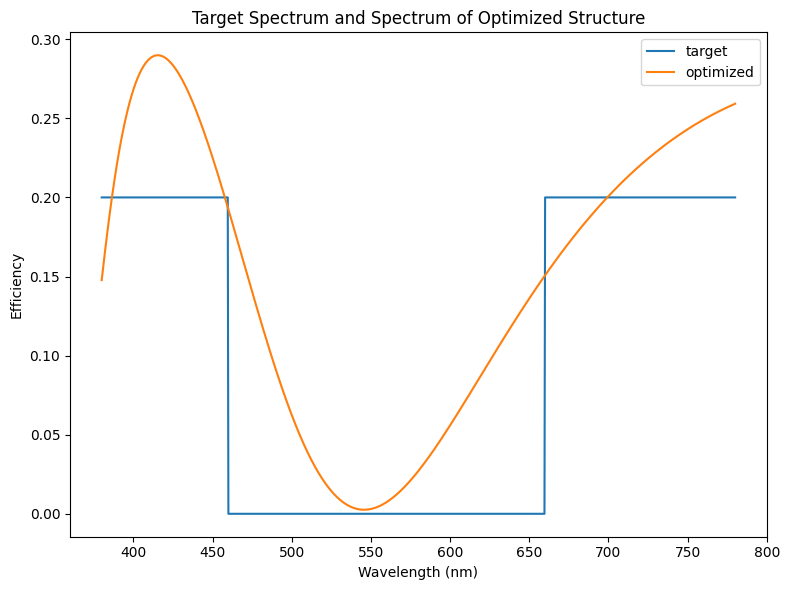

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(wavelengths_in_nm, target_spectrum, label='target')
ax.plot(wavelengths_in_nm, spectrum_optimized, label='optimized')

ax.set_title(f"Target Spectrum and Spectrum of Optimized Structure")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Efficiency")

plt.legend()
plt.tight_layout()
plt.show()